In [1]:
# import tensorflow as tf
# sess = tf.Session()
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# import pandas 

from process_data import *
import os
from n_gram_lm import *


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11138713817207994321
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 3959130084359561883
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [17]:
# Problem parameters
max_mfe_len = 1800
max_phrase_len = 250
n_energies = 40
n_phonemes = 40+1 # 26 chars, 1 space, 1 blank
blank_idx = n_letters - 1

In [18]:
model_name = "densenet_phon_b1.l5.f64.k5.relu"

In [19]:
print "Loading model", model_name
json_file = open("saved_models/"+model_name)
json = json_file.read()
model = keras.models.model_from_json(json)
sgd = Adam(lr=0.001)
print "Compiling..."
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss (y_pred is actually loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred, 'phoneme_probs': lambda y_true, y_pred: 0*y_pred}, optimizer=sgd)

print "Looking for weight files..."

filenames = os.listdir("saved_weights")
model_regex = r"^"+model_name+r"-([0-9]+)-([+-]?([0-9]*[.])?[0-9]+)\.hdf5"
highest_epoch = None
latest = None
for k in filenames:
    match =  re.match(model_regex, k)
    if match:

        epochs_done = int(match.group(1))
        val_loss = float(match.group(2))
        print "File", k, "contains weights after {} epochs achieving validation loss: {}".format(epochs_done, val_loss)
        # If this is the first file, or if there is a more recent one
        if not highest_epoch or epochs_done > highest_epoch:
            highest_epoch = max(epochs_done, highest_epoch)
            latest = k
        else:
            continue
if latest:
    print "Latest weights are from {}".format(latest)

    print "Loading weights..."
    model.load_weights('saved_weights/'+latest)
    print "Done"
else:
    print "Didn't find any weight files for this model!"
    epochs_done = 0

Loading model densenet_phon_b1.l5.f64.k5.relu
Compiling...
Looking for weight files...
File densenet_phon_b1.l5.f64.k5.relu-1-257.414057785.hdf5 contains weights after 1 epochs achieving validation loss: 257.414057785
File densenet_phon_b1.l5.f64.k5.relu-3-235.811444254.hdf5 contains weights after 3 epochs achieving validation loss: 235.811444254
File densenet_phon_b1.l5.f64.k5.relu-4-203.461526711.hdf5 contains weights after 4 epochs achieving validation loss: 203.461526711
File densenet_phon_b1.l5.f64.k5.relu-0-268.487241622.hdf5 contains weights after 0 epochs achieving validation loss: 268.487241622
File densenet_phon_b1.l5.f64.k5.relu-6-216.794131501.hdf5 contains weights after 6 epochs achieving validation loss: 216.794131501
File densenet_phon_b1.l5.f64.k5.relu-5-242.320231912.hdf5 contains weights after 5 epochs achieving validation loss: 242.320231912
File densenet_phon_b1.l5.f64.k5.relu-2-217.434513108.hdf5 contains weights after 2 epochs achieving validation loss: 217.434513

In [20]:
model.load_weights("saved_weights/densenet_phon_b1.l5.f64.k5.relu-4-203.461526711.hdf5")

In [21]:
batch_size = 16
lib_fnames_val = ['Libri_data_lib/data_padded_phon_8.npz', 'Libri_data_lib/data_padded_phon_9.npz']
valid_data_gen = batch_generator(batch_size, lib_fnames_val, max_mfe_len, n_phonemes)

In [15]:
# total_data_size = 65040
# val_split = 0.8
# total_steps = int(np.ceil(float(total_data_size)/batch_size))
# training_steps = int(np.ceil(total_data_size*0.8/batch_size ))
# val_steps = int(np.ceil(total_data_size*0.2/batch_size ))
# # print val_steps
# print total_steps*batch_size, training_steps*batch_size, val_steps*batch_size

65040 52032 13008


In [22]:
inputs_valid, outputs_valid = valid_data_gen.next()
# print inputs_valid.keys()
X_valid = inputs_valid["log_mfes"]
input_lengths_valid= inputs_valid["input_length"]
y_valid= inputs_valid["the_labels"]
label_lengths_valid= inputs_valid["label_length"]

ctc_costs, c_probs = model.predict(inputs_valid)
c_probs.shape

(16, 1800, 41)

In [23]:
p_dict = np.load("language_model_dat/1-billion-word/smoothed-probs.npy").flat[0]

In [10]:
rev_alph = dict(zip("abcdefghijklmnopqrstuvwxyz -", range(28)))
alphabet = "abcdefghijklmnopqrstuvwxyz "
def prob_lm_helper(prob_dict, string, c):
    if not string:
        return prob_dict[c]/np.sum(np.asarray([prob_dict[x] for x in alphabet]))
    else:
        return prob_dict[string[-4:] + c]/prob_dict[string[-4:]]

def prob_lm(string, c):
    return prob_lm_helper(p_dict, string , c)

def prob_char_helper(char_probs, t, char):
    return char_probs[t, rev_alph[char]]


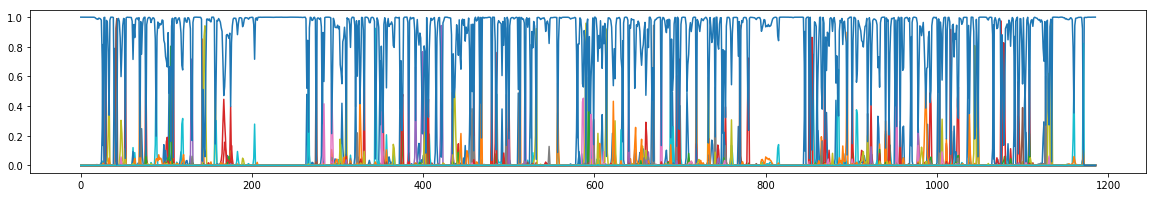

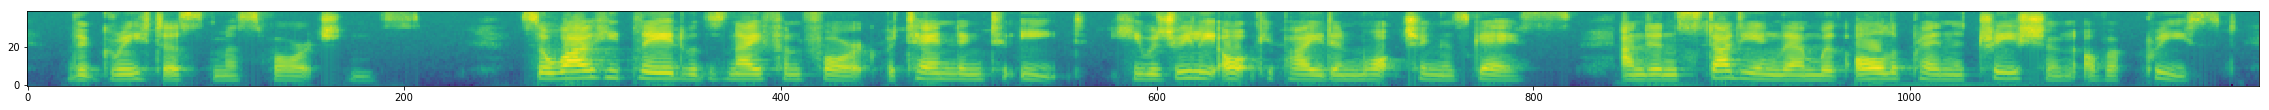

In [65]:

checking_idx = 2
plt.figure(figsize=(20,3))
plt.plot(c_probs[checking_idx, :input_lengths_valid[checking_idx]]);

fig, ax = plt.subplots(figsize=(40,100))
mfcc_data= np.swapaxes(X_valid[checking_idx, :input_lengths_valid[checking_idx]], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')

In [66]:
# argmaxes = np.argmax(c_probs[checking_idx], axis=1)
phonemes = interpret_probs(c_probs[checking_idx, :input_lengths_valid[checking_idx]], ignore_blanks = False)
print "".join([x for x in phonemes if x!="-"])

DHAHR GEYTAHSMAHFAARCHSOW AYIY LEYD AH NAYFFAHN FAAR AH TEYNIHNTUW IYT IYM AHIY AO PAYDAHNAACHIH AHGEY AHND NSTAHIHNEHN WIH AOLAH PEHNAH REYSHAHN AH AHPRIYSD 


In [67]:
arpabet = nltk.corpus.cmudict.dict()
def strip_num(phone):
    if phone[-1].isdigit():
        return phone[:-1]
    else:
        return phone

phone_word = [(map(strip_num, v[0]), k) for (k, v) in arpabet.items()]

rev_dict = {}
for (k,v) in phone_word:
    prop_key = " ".join(k)
    if prop_key in rev_dict:
        rev_dict[prop_key] += [v]
    else:
        rev_dict[prop_key] = [v]
            import itertools

phoneme_list = interpret_code(y_valid[checking_idx, :label_lengths_valid[checking_idx]])

" ".join([rev_dict[" ".join(g)][0] for k,g in itertools.groupby(phoneme_list,lambda x:x==" ") if not k])

u"the greatest misfortunes sew weill hee played with his knife and fork pretending two eat hee wah's really occupied in watching his guest's and in studying them with aul the penetration of uh priest"

In [51]:
T = 300
n_paths = 100
alpha = 1.25
beta = 0
prob_char = lambda t, char : prob_char_helper(c_probs[checking_idx], t, char)
(Z, p_s) = beam_search(T, n_paths, alpha, beta, prob_char, prob_lm)

NameError: name 'prob_lm' is not defined

In [16]:
Z[T]

['ma',
 'he wi',
 ' i',
 ' beg',
 'd ',
 ' bea',
 ' n',
 'r ',
 'them',
 'ea',
 'ge',
 ' ben',
 'hem ',
 're',
 'a ',
 'ne',
 'he wo',
 'em',
 'mot',
 'kee',
 'g ',
 ' b',
 'c',
 'he m',
 'f',
 ' wo',
 'be',
 'hed',
 'head ',
 'en',
 'he e',
 'm ',
 ' a',
 'l',
 'n ',
 'ing ',
 'w',
 ' wi',
 ' m',
 'ad ',
 'se ',
 's',
 ' e',
 'highe',
 'whe',
 'he wa',
 'ked ',
 'high ',
 'p',
 'me',
 'ke ',
 'hle',
 'v',
 'hei',
 'u',
 ' the ',
 ' wa',
 'ehe',
 't',
 'h',
 'her',
 'he we',
 'hee',
 'hing',
 'hea',
 'hethe',
 ' bee',
 'hen',
 'e ',
 ' th',
 ' be ',
 'mon',
 'hem',
 'd',
 ' tha',
 'the ',
 ' we',
 'r',
 'ing',
 'g',
 'b',
 'o',
 'ed ',
 'i',
 ' the',
 'high',
 'wh',
 'a',
 'm',
 'n',
 'ke',
 'the',
 'he ',
 'he w',
 ' be',
 'e',
 ' w',
 ' ',
 'he',
 '']

In [13]:
alphabet_ = "abcdefghijklmnopqrstuvwxyz -"
predicted_chars = [alphabet_[idx] for idx in list(np.argmax(c_probs[checking_idx], axis=1))]
tracker = ""
chars_out_wb = []
for char in predicted_chars:
    if char != tracker:
        chars_out_wb.append(char)
        tracker = char
chars_out = [c for c in chars_out_wb if c !="-"]

print "".join(chars_out)
print
actual_chars = [alphabet[idx] for idx in list(y_valid[checking_idx, :label_lengths_valid[checking_idx]]) if alphabet_[idx]!="-"]
print "".join(actual_chars)
print len(actual_chars)

eigheebeawg insiagmererglybgvemfon twe hntahbgpohaphothghzyjcqxzjzj

i mean jumping he looks as if he had wings insisted jumper stubbornly that is simply because i have given him a fold of skin between the front and hind leg on each side explained old mother nature
196
